In [86]:
import csv
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Data Loading

In [87]:
import datasets
import torchvision.transforms as transforms

tensor_transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.C100Dataset('dataset/data/cifar100_nl.csv', 'dataset/data/cifar100_nl_test.csv')
[trainData, trainLabels, testData, testLabels] = dataset.getDataset()




Test set shape: (9999, 32, 32, 3)
Test labels shape: (9999,)
Training set shape: (49999, 32, 32, 3)
Training labels shape: (49999,)


In [88]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Assuming trainData, trainLabels, valData, and valLabels are numpy arrays
trainData, valData, trainLabels, valLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=42)

trainData = trainData / 255.0
valData = valData / 255.0
testData = testData / 255.0

import numpy as np

# Assuming trainData is your numpy array containing the training data

# Calculate the mean
mean = np.mean(trainData, axis=(0, 1, 2))  # Compute mean along each channel

# Calculate the standard deviation
std = np.std(trainData, axis=(0, 1, 2))  # Compute standard deviation along each channel

print("Mean:", mean)
print("Standard Deviation:", std)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),    # Convert to tensor
    transforms.Normalize((0.50764684, 0.48674372, 0.44104357), (0.26745035, 0.25658456, 0.27634654))    # Normalize the data
])


Mean: [0.50764684 0.48674372 0.44104357]
Standard Deviation: [0.26745035 0.25658456 0.27634654]


In [89]:
# Mean: [0.50764684 0.48674372 0.44104357]
# Standard Deviation: [0.26745035 0.25658456 0.27634654]
stats = ((0.50764684, 0.48674372, 0.44104357), (0.26745035, 0.25658456, 0.27634654))

In [90]:

trainData = torch.stack([transform(image) for image in trainData])
valData = torch.stack([transform(image) for image in valData])
testData = torch.stack([transform(image) for image in testData])

# Convert numpy arrays to torch tensors
trainLabels = torch.from_numpy(trainLabels)
valLabels = torch.from_numpy(valLabels)
testLabels = torch.from_numpy(testLabels)


# Label smoothing
label_smoothing = 0
num_classes = 100

if label_smoothing > 0:
    trainLabels = trainLabels * (1 - label_smoothing) + label_smoothing / num_classes
    valLabels = valLabels * (1 - label_smoothing) + label_smoothing / num_classes
    testLabels = testLabels * (1 - label_smoothing) + label_smoothing / num_classes


# Convert to float
trainData = trainData.to(torch.float32)
trainLabels = trainLabels.to(torch.int64)
valData = valData.to(torch.float32)
valLabels = valLabels.to(torch.int64)
testData = testData.to(torch.float32)
testLabels = testLabels.to(torch.int64)

# Create TensorDatasets
trainDataset = TensorDataset(trainData, trainLabels)
valDataset = TensorDataset(valData, valLabels)
testDataset = TensorDataset(testData, testLabels)

# Create DataLoaders
trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=256, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=256, shuffle=False)


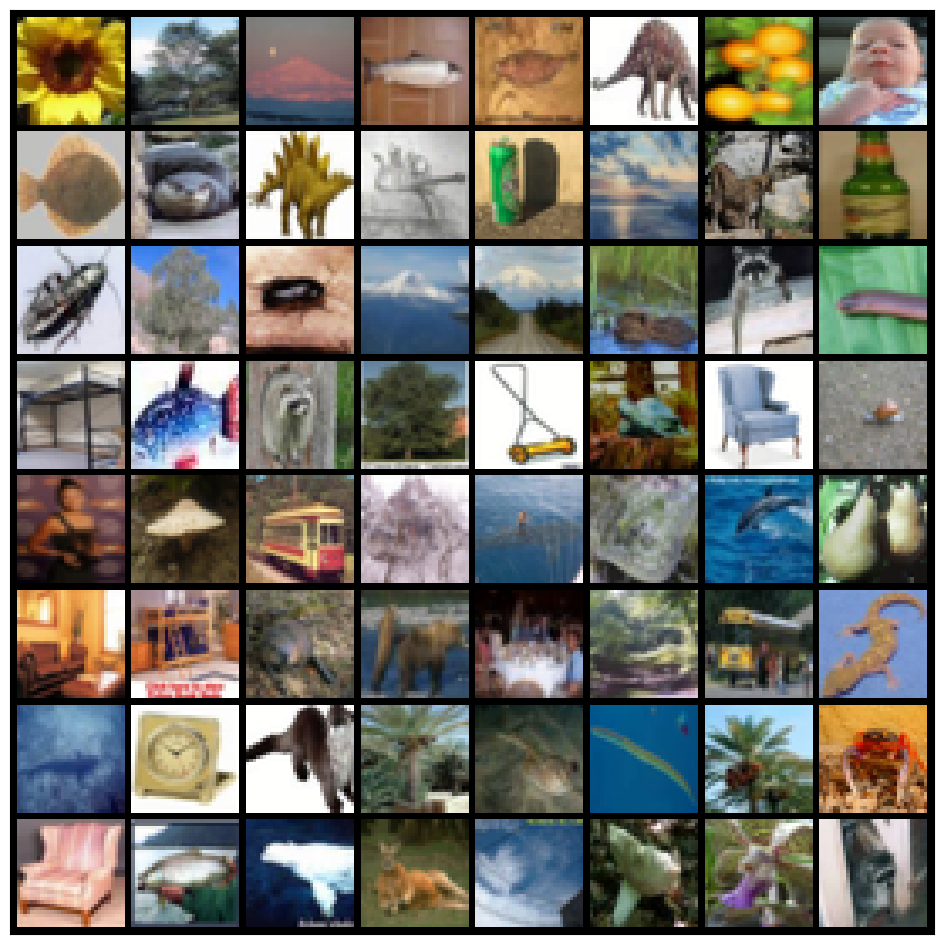

In [91]:
#Show image for fun
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(trainLoader)


Move to CUDA 

In [92]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

def to_device(entity, device):
    """Move tensor(s) to chosen device"""
    if isinstance(entity, (list,tuple)):
        return [to_device(x, device) for x in entity]
    return entity.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for entity in self.loader:
            yield to_device(entity, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.loader)
    
trainLoader = DeviceDataLoader(trainLoader, device)
testLoader = DeviceDataLoader(testLoader, device)
valLoader = DeviceDataLoader(valLoader, device)

Model Architecture

In [93]:
## ResNet

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]

    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)  # Increase the output channels
        self.conv2 = conv_block(128, 256, pool=True)  # Increase the output channels
        self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.conv3 = conv_block(256, 512, pool=True)  # Increase the output channels
        self.conv4 = conv_block(512, 1024, pool=True)  # Increase the output channels
        self.res2 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(1024, num_classes))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        return self.classifier(out)



In [94]:
# Select training model

from cnn import CNN
from torchvision.models import resnet50, ResNet50_Weights
from Coteach import CNN

model = ResNet(3, 100)

Model training

In [ ]:
import sklearn.metrics as metrics

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [95]:
def train(model, train_dl, val_dl, test_dl, epochs, max_lr, loss_func, optim, warmup_epochs):
    # Initalize the optimizer 
    optimizer = optim(model.parameters(), max_lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs * len(train_dl), steps_per_epoch = len(train_dl))

    results = []
    lrs = []
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []


        # Apply warm-up learning rate for the specified number of epochs
        if epoch < warmup_epochs:
            warmup_lr = max_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr

        train_losses = []
        train_accs = []
        for images, labels in train_dl:
            logits = model(images)
            loss = loss_func(logits, labels)

            batch_losses.append(loss)
            batch_accs.append(accuracy(logits, labels))

            loss.backward()
            train_losses.append(loss)
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            lrs.append(optimizer.param_groups[0]['lr'])

        epoch_train_loss = torch.stack(train_losses).mean()
        epoch_train_acc = torch.stack(train_accs).mean()

        model.eval()
        batch_losses = []
        batch_accs = []
        for images, labels in val_dl:
            with torch.no_grad():
                logits = model(images)
            batch_losses.append(loss_func(logits, labels))
            batch_accs.append(accuracy(logits, labels))
        epoch_val_loss = torch.stack(batch_losses).mean().item()
        epoch_val_acc = torch.stack(batch_accs).mean()


        test_losses = []
        test_accs = []
        for images, labels in test_dl:
            with torch.no_grad():
                logits = model(images)
            test_losses.append(loss_func(logits, labels))
            test_accs.append(accuracy(logits, labels))
        epoch_test_loss = torch.stack(test_losses).mean().item()
        epoch_test_acc = torch.stack(test_accs).mean()

        results.append({
            'avg_train_loss': epoch_train_loss,
            'avg_train_accuracy': epoch_train_acc,
            'avg_validation_loss': epoch_val_loss,
            'avg_validation_accuracy': epoch_val_acc,
            'avg_testing_loss': epoch_test_loss,
            'avg_testing_accuracy': epoch_test_acc
        })

    return results, lrs

In [96]:
print(results)

[{'avg_validation_loss': 3.7945709228515625, 'avg_train_loss': tensor(4.3372, device='cuda:0', grad_fn=<MeanBackward0>), 'avg_validation_accuracy': tensor(0.1697, dtype=torch.float64), 'avg_testing_loss': 3.4042975902557373, 'avg_testing_accuracy': tensor(0.2154, dtype=torch.float64)}, {'avg_validation_loss': 3.5634021759033203, 'avg_train_loss': tensor(3.8221, device='cuda:0', grad_fn=<MeanBackward0>), 'avg_validation_accuracy': tensor(0.2227, dtype=torch.float64), 'avg_testing_loss': 3.075282335281372, 'avg_testing_accuracy': tensor(0.2845, dtype=torch.float64)}, {'avg_validation_loss': 3.3752689361572266, 'avg_train_loss': tensor(3.5277, device='cuda:0', grad_fn=<MeanBackward0>), 'avg_validation_accuracy': tensor(0.2567, dtype=torch.float64), 'avg_testing_loss': 2.791274309158325, 'avg_testing_accuracy': tensor(0.3412, dtype=torch.float64)}, {'avg_validation_loss': 3.2736198902130127, 'avg_train_loss': tensor(3.3064, device='cuda:0', grad_fn=<MeanBackward0>), 'avg_validation_accurac

In [104]:
# Parameters

model = to_device(model, device)
epochs = 20
max_lr = 1e-2
loss_func = F.cross_entropy
optim = torch.optim.Adam
warmup_epochs = 2 # Number of warmup epochs for the learning rate scheduler

# Add these to an array to print
parameters = [epochs, max_lr, loss_func, optim, warmup_epochs]

In [105]:
results, lrs = train(model, trainLoader, valLoader, testLoader, epochs, max_lr, loss_func, optim, warmup_epochs)

print(parameters)
for i, result in enumerate(results):
    print("Epoch {}: {:.4f}".format(i + 1, result["avg_validation_accuracy"]))

[20, 0.01, <function cross_entropy at 0x000002198DDA2B90>, <class 'torch.optim.adam.Adam'>, 0]
Epoch 1: 0.3934
Epoch 2: 0.4130
Epoch 3: 0.4188
Epoch 4: 0.4089
Epoch 5: 0.4080
Epoch 6: 0.4172
Epoch 7: 0.4250
Epoch 8: 0.4192
Epoch 9: 0.4018
Epoch 10: 0.4150
Epoch 11: 0.4161
Epoch 12: 0.4043
Epoch 13: 0.4063
Epoch 14: 0.4151
Epoch 15: 0.4245
Epoch 16: 0.3999
Epoch 17: 0.3913
Epoch 18: 0.4068
Epoch 19: 0.4031
Epoch 20: 0.4039


Evaluation

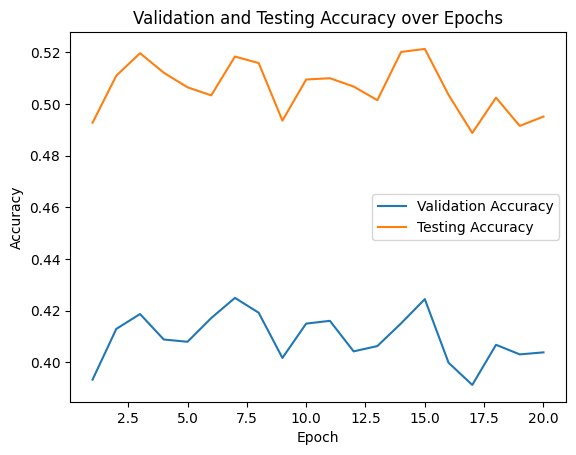

In [106]:
# Extract the accuracy values from the results
validation_accuracies = [result['avg_validation_accuracy'] for result in results]
testing_accuracies = [result['avg_testing_accuracy'] for result in results]

# Plot accuracy over epochs
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy')
plt.plot(range(1, len(testing_accuracies) + 1), testing_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and Testing Accuracy over Epochs')
plt.legend()
plt.show()